# Predict the effect of Genetic Variants

- 암이 이해하기 어렵고 치료가 어려운 주된 이유 중 하나는 종양 유전자 돌연변이가 다양하고 복접하기 때문임.
- 종양 세포에는 수천 개의 유전자가 있으며 이들 각각의 유전자는 수천 개의 알려진 돌연변이와 아직 발견되지 않은 수많은 돌연변이를 가질 수 있다. 하지만, 모든 돌연변이가 암인 것은 아니며 그 중 일부는 양성일 수 있다. 결국, 유전자는 자연 진화의 일부로 계속 돌연변이를 일으키며, 각 돌연변이가 유기체에 해로운 것은 아니다. 
- 효과적인 항암제를 개발하기 위해 약물 연구자는 종양에서 대부분의 돌연변이의 특성을 알아야 한다.
- 그러나, 종양 유전자 돌연변이를 분류하는 과정은 수동적이고 힘들며 시간이 많이 걸리는 작업임. 실험실의 종양 표본에서 발견된 각 돌연변이에 대해 연구자는 발견된 돌연변이를 적절한 클래스로 분류하기 위해 여러 페이지의 의학 문헌을 검토해야 한다.


-  Personalized Medicine Dataset that was compiled and released by the Memorial Sloan Kettering Cancer Center (MSKCC) for a Kaggle Competition that they hosted in 2017. 
- This dataset contains research papers from various medical journals about studies on tumor gene mutation classification. The training dataset has 3321 such papers. **Each paper is about a particular gene and a mutation associated with it.**
- **Expert cancer researchers have annotated these mutations in one of the nine classes (1–9).** 
- While it is not stated in the Kaggle Competition what these classes of mutations represent, someone found from an article in an edited compilation¹ that they could very likely mean the following:
  - https://towardsdatascience.com/distributed-biomedical-text-mining-using-pyspark-for-classification-of-cancer-gene-mutations-3e11507b2450
  - class 1: Gain of function
  - class 2: Likely gain of function
  - class 3: Loss of function
  - class 4: Likely loss of function
  - class 5: Neutral
  - class 6: Likely neutral
  - class 7: Switch of function
  - class 8: Likely switch of function
  - class 9: Inconclusive

Features
- Id: The id of the row used to link the mutation to the clinical evidence (Numerical)
- Gene: The gene where this genetic mutation is located (Categorical) - 유전자
- Variants: The aminoacid change for this mutations (Categorical) - 변이
- Text: Text collected from the clinical evidences (Text) -임상실험 논문 또는 보고서
- Class: 1-9 the class this genetic mutation has been classified on (Numeric) - 전문가 의견

In [1]:
import os
import re
import tqdm
import string
import pandas as pd
import numpy as np
from tensorflow import keras

# Using CountVectorizer
- original problem in https://www.kaggle.com/c/msk-redefining-cancer-treatment
- the python code based on https://www.kaggle.com/fugacity/personalized-medicine-multiclass-classification/notebook

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
import warnings
import numpy as np
import pandas as pd
from collections import Counter
from scipy.sparse import hstack
from collections import Counter, defaultdict
import math
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import confusion_matrix, log_loss
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold 
from sklearn import model_selection
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.model_selection import train_test_split
# from mlxtend.classifier import StackingClassifier
from IPython.display import Image
warnings.filterwarnings("ignore")
%matplotlib inline

## 1. Data preparation

In [4]:
data_variants = pd.read_csv('training_variants.zip')
data_text =pd.read_csv("training_text.zip",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)

In [5]:
import nltk
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def data_text_preprocess(total_text, ind, col):
    if type(total_text) is not int:
        string = ""
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', str(total_text))  # special character -> space
        total_text = re.sub('\s+',' ', str(total_text)) # multiple spaces -> single space
        total_text = total_text.lower()                 # to lower case
        
        for word in total_text.split():
            if not word in stop_words:
                string += word + " "
        
        data_text[col][ind] = string

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
def data_text_preprocess2(text, ind, col):
    if type(text) is int: 
        return

    str_ = ""
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = text.lower().split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]    
    text = " ".join(text)
    text= text.translate(str.maketrans("","", string.punctuation))

    for word in text.split():
        if not word in stop_words:
            str_ += word + " "
        
    data_text[col][ind] = str_
    return

In [7]:
data_text.head()

,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [8]:
data_variants.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [9]:
data_text.shape

(3321, 2)

In [10]:
for index, row in data_text.iterrows():
    if type(row['TEXT']) is str:
        data_text_preprocess(row['TEXT'], index, 'TEXT')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [12]:
data_text.head()

,ID,TEXT
0,0,cyclin dependent kinases cdks regulate variety...
1,1,abstract background non small cell lung cancer...
2,2,abstract background non small cell lung cancer...
3,3,recent evidence demonstrated acquired uniparen...
4,4,oncogenic mutations monomeric casitas b lineag...


In [15]:
all_data = pd.merge(data_variants, data_text, on='ID', how='left')
all_data.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


- For example, the paper with ID 1 is about the CBL gene and its variation(mutation) W802*. This mutation belongs to class 2.
- It is a dense scientific paper that contains several biological terms and overall, it contains 5757 words. It will take at least few hours to read a paper.
- What if a tumor gene contains 10 different mutations which is a modest number for the number of mutations that can be present?

Text(0.5, 1.0, 'Data count by Class')

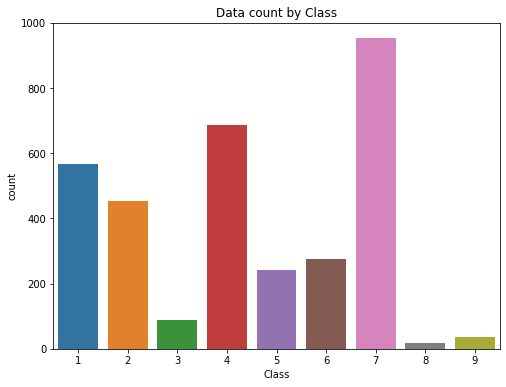

In [16]:
plt.figure(figsize=(8,6))
sns.countplot(x='Class', data=all_data)
plt.gca().xaxis.tick_bottom()
plt.title('Data count by Class')

In [17]:
all_data[all_data.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [18]:
missing_rows_index = all_data[all_data.isnull().any(axis=1)].index
all_data.loc[missing_rows_index]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [19]:
# Adding Variation column to TEXT
all_data.loc[all_data['TEXT'].isnull(),'TEXT'] = all_data['Gene'] + ' ' + all_data['Variation'] 

In [20]:
all_data.loc[missing_rows_index]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,FANCA S1088F
1277,1277,ARID5B,Truncating Mutations,1,ARID5B Truncating Mutations
1407,1407,FGFR3,K508M,6,FGFR3 K508M
1639,1639,FLT1,Amplification,6,FLT1 Amplification
2755,2755,BRAF,G596C,7,BRAF G596C


In [21]:
# replaceing spaces with '_'
y_true = all_data['Class'].values
all_data['Gene']      = all_data['Gene'].str.replace('\s+', '_')
all_data['Variation'] = all_data['Variation'].str.replace('\s+', '_')

In [22]:
all_data.loc[missing_rows_index]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,FANCA S1088F
1277,1277,ARID5B,Truncating_Mutations,1,ARID5B Truncating Mutations
1407,1407,FGFR3,K508M,6,FGFR3 K508M
1639,1639,FLT1,Amplification,6,FLT1 Amplification
2755,2755,BRAF,G596C,7,BRAF G596C


## 2. Split dataset into Train and Test 

In [23]:
X_train, X_test, y_train, y_test = train_test_split(all_data, y_true, stratify = y_true, test_size=0.2)
print('train data:', X_train.shape, y_train.shape)
print('test data:', X_test.shape, y_test.shape)

train data: (2656, 5) (2656,)
test data: (665, 5) (665,)


[]

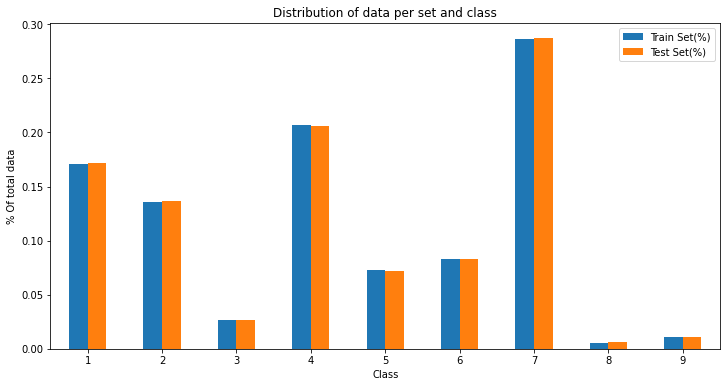

In [24]:
X_train_distribution = X_train['Class'].value_counts() / X_train.shape[0]
X_test_distribution = X_test['Class'].value_counts() / X_test.shape[0]

train_set = pd.Series(X_train_distribution).sort_index()
test_set = pd.Series(X_test_distribution).sort_index()

pd.DataFrame(  {
     'Train Set(%)': train_set,
     'Test Set(%)':test_set
    }).plot.bar(figsize=(12,6))
plt.title('Distribution of data per set and class')
plt.xticks(rotation=0)
plt.xlabel('Class')
plt.ylabel('% Of total data')
plt.plot()

- Data is distributed quite evenly across sets.

In [25]:
X_train.head()

,ID,Gene,Variation,Class,TEXT
1399,1399,FGFR3,N540S,7,frequent genetic alterations discovered fgfrs ...
1210,1210,PIK3CA,G106_R108del,2,lung cancer one prevalent cancers worldwide st...
3062,3062,MED12,Exon_2_mutations,2,uterine leiomyomas benign smooth muscle tumors...
3014,3014,KIT,N463S,2,context melanomas arising acral mucosal chroni...
2994,2994,KIT,D419del,7,gastrointestinal stromal tumors gists often as...


In [26]:
y_train[:5]

array([7, 2, 2, 2, 7])

## 3. Feature analysis and featurization

In [27]:
def model_performance(name, clf, alpha, train_x, train_y, test_x, test_y):
    clf = clf
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    
    train_y_pred = sig_clf.predict_proba(train_x)
    train_log_loss = np.round(log_loss(train_y, train_y_pred, labels=clf.classes_),3)
    
    test_y_pred = sig_clf.predict_proba(test_x)
    test_log_loss = np.round(log_loss(test_y, test_y_pred, labels=clf.classes_),3)
    
    y_pred = sig_clf.predict(test_x)
    
    accuracy = sig_clf.score(test_x, test_y)
    
    report_perf=[name,
                 alpha,
                 train_log_loss,
                 test_log_loss,
                 accuracy]
    
    temp_df = pd.DataFrame([report_perf], 
                           columns=['Model','alpha','train_log_loss','test_log_loss','Accuracy(%)'])   
    return temp_df, y_pred

### 3.1 Genes and Variations features

In [28]:
print ('Number of unique Genes:',len(X_train['Gene'].unique()), len(X_test['Gene'].unique()))
print ('Number of unique Variations:',len(X_train['Variation'].unique()), len(X_test['Variation'].unique()))

Number of unique Genes: 252 146
Number of unique Variations: 2404 615


In [30]:
# top 10 Genes that accurred the most
X_train['Gene'].value_counts().head(10)

BRCA1     214
TP53      128
EGFR      118
BRCA2     102
PTEN       99
KIT        85
BRAF       74
ALK        54
PDGFRA     49
ERBB2      49
Name: Gene, dtype: int64

In [31]:
vectorizer = CountVectorizer()    # one-hot encoding 효과
X_train_Gene =  vectorizer.fit_transform(X_train['Gene'])
X_test_Gene  =  vectorizer.transform(X_test['Gene'])

In [32]:
alpha = 0.001
clf = SGDClassifier(class_weight='balanced', alpha=alpha, penalty='l2', loss='log', random_state=42)
model_performance('Logistic Regression',
                  clf,
                  alpha,
                  X_train_Gene, y_train,
                  X_test_Gene, y_test)[0]

,Model,alpha,train_log_loss,test_log_loss,Accuracy(%)
0,Logistic Regression,0.001,1.099,1.244,0.55188


- We can see that Gene feature is reasonably stable across the train and test dataset.

In [34]:
# top 10 Variations that occurred the most
X_train['Variation'].value_counts().head(10)

Truncating_Mutations    73
Deletion                66
Amplification           57
Fusions                 25
Overexpression           4
Q61H                     3
Q61L                     3
T58I                     3
Q61R                     2
F384L                    2
Name: Variation, dtype: int64

In [35]:
vectorizer = CountVectorizer()    # one hot encoding 효과
X_train_Variation =  vectorizer.fit_transform(X_train['Variation'])
X_test_Variation  =  vectorizer.transform(X_test['Variation'])

In [36]:
alpha = 0.001
clf = SGDClassifier(class_weight='balanced', alpha=alpha, penalty='l2', loss='log', random_state=42)
model_performance('Logistic Regression',
                  clf,
                  alpha,
                  X_train_Variation, y_train,
                  X_test_Variation, y_test)[0]

,Model,alpha,train_log_loss,test_log_loss,Accuracy(%)
0,Logistic Regression,0.001,1.147,1.714,0.338346


- Variation feature is also considered to be stable across the train and test dataset (not more than Gene).

In [37]:
X_train_Gene.toarray().shape, X_train_Variation.toarray().shape

((2656, 251), (2656, 2435))

In [38]:
np.concatenate([X_train_Gene.toarray(), X_train_Variation.toarray()], axis=1).shape

(2656, 2686)

In [39]:
X_train_Comb = np.concatenate([X_train_Gene.toarray(), X_train_Variation.toarray()], axis=1)
X_test_Comb = np.concatenate([X_test_Gene.toarray(), X_test_Variation.toarray()], axis=1)
alpha = 0.001
clf = SGDClassifier(class_weight='balanced', alpha=alpha, penalty='l2', loss='log', random_state=42)
model_performance('Logistic Regression',
                  clf,
                  alpha,
                  X_train_Comb, y_train,
                  X_test_Comb, y_test)[0]

,Model,alpha,train_log_loss,test_log_loss,Accuracy(%)
0,Logistic Regression,0.001,0.855,1.167,0.606015


- little better than single feature data

### 3.2 Featuring Text data

- let's see what words are the mostly occurred in each class

In [40]:
text_vectorizer = CountVectorizer(max_features=10000, min_df=3)
X_train_Text = text_vectorizer.fit_transform(X_train['TEXT'])
X_test_Text = text_vectorizer.transform(X_test['TEXT'])

# getting all the feature names (words)
X_train_Text_features = text_vectorizer.get_feature_names()
print("Total number of unique words in train data :", len(X_train_Text_features))

Total number of unique words in train data : 10000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# classs i 에서 대한 전체 count(or tfidf) 값이 높은 top_n 개의 단어
def class_features(i, top_n = 10):
    if top_n > len(y_train[y_train == i]):
        top_n = len(y_train[y_train == i])
    idx = X_train_Text[y_train == i].toarray().sum(axis=0).argsort()[::-1][:top_n]
    features = [text_vectorizer.get_feature_names()[i] for i in idx]
    return features

In [ ]:
print("The most occurred 10 features for each class: ")
for i in range(1,10):
    words = class_features(i,10)
    print ("class {}: ".format(i), words)

The most occurred 10 features for each class: 
class 1:  ['mutations', 'cells', 'p53', 'cell', 'et', 'al', 'cancer', 'fig', 'protein', 'figure']
class 2:  ['mutations', 'cells', 'patients', 'cell', 'mutation', 'et', 'al', 'cancer', 'figure', 'kinase']
class 3:  ['mutations', 'brca1', 'cells', 'al', 'et', 'variants', 'cancer', 'alk', 'figure', 'mutation']
class 4:  ['mutations', 'cells', 'pten', 'protein', 'et', 'al', 'fig', 'activity', 'cell', 'figure']
class 5:  ['brca1', 'variants', 'mutations', 'cancer', 'cells', 'protein', 'functional', 'mutation', 'fig', 'type']
class 6:  ['brca1', 'variants', 'mutations', 'cancer', 'mutation', 'deleterious', 'cells', 'data', 'fig', 'binding']
class 7:  ['mutations', 'cells', 'cell', 'patients', 'egfr', 'mutation', 'fig', 'kinase', 'figure', 'et']
class 8:  ['cells', 'mutations', 'al', 'et', 'expression', 'figure', 'cell', 'genes', 'mutant', 'fig']
class 9:  ['cells', 'mutations', 'mutant', 'sf3b1', 'splicing', 'cell', 'figure', 'et', 'al', 'idh1'

- Now we see that tfidf will be better than countvectorizer.

In [ ]:
# tfidf vectorizer
text_vectorizer = TfidfVectorizer(max_features=10000, min_df=3)
X_train_Text = text_vectorizer.fit_transform(X_train['TEXT'])
X_test_Text = text_vectorizer.transform(X_test['TEXT'])

# getting all the feature names (words)
X_train_Text_features = text_vectorizer.get_feature_names()
print("Total number of unique words in train data :", len(X_train_Text_features))

Total number of unique words in train data : 10000


In [ ]:
print("The most occurred 10 features for each class: ")
for i in range(1,10):
    words = class_features(i,10)
    print ("class {}: ".format(i), words)

The most occurred 10 features for each class: 
class 1:  ['p53', 'mutations', 'brca1', 'variants', 'cells', 'fig', 'brct', 'et', 'al', 'cancer']
class 2:  ['mutations', 'patients', 'egfr', 'imatinib', 'cells', 'mutation', 'kit', 'al', 'et', 'kinase']
class 3:  ['brca1', 'mutations', 'mtor', 'alk', 'flt3', 'pdgfra', 'cells', 'al', 'variants', 'et']
class 4:  ['pten', 'mutations', 'p53', 'cells', 'brca1', 'variants', 'activity', 'al', 'et', 'protein']
class 5:  ['brca1', 'variants', 'vus', 'brct', 'mutations', 'neutral', 'cancer', 'deleterious', 'brca2', 'variant']
class 6:  ['brca1', 'variants', 'deleterious', 'vus', 'brca2', 'brca', 'mutations', 'odds', 'neutral', 'vuss']
class 7:  ['mutations', 'egfr', 'cells', 'cell', 'fig', 'kinase', 'patients', 'alk', 'ras', 'mutation']
class 8:  ['k42a', 'bcor', 'h3', 'akt', 'idh1', '2hg', 'cells', 'al', 'et', 'gbm']
class 9:  ['sf3b1', 'splicing', '2hg', 'u2af1', 'mds', 'ezh2', 'idh1', 'u2af35', 'idh', 'sf3b1mut']


In [ ]:
X_train_Text.shape, X_test_Text.shape

((2656, 10000), (665, 10000))

In [ ]:
X_train_Text_features[:10]

['00', '000', '0001', '0002', '0008', '001', '002', '003', '004', '005']

In [ ]:
# do not forget to normalize every feature
X_train_Text = normalize(X_train_Text, axis=0)
X_test_Text = normalize(X_test_Text, axis=0)

In [ ]:
X_train_Gene.shape, X_train_Variation.shape, X_train_Text.shape

((2656, 248), (2656, 2442), (2656, 10000))

### 3.3 Stacking all the fatures

In [ ]:
# stacking
X_train_stacked = hstack([hstack([X_train_Gene, X_train_Variation]), X_train_Text])
X_test_stacked  = hstack([hstack([X_test_Gene, X_test_Variation]), X_test_Text])

In [ ]:
X_train_stacked.shape, X_test_stacked.shape, y_train.shape, y_test.shape

((2656, 12690), (665, 12690), (2656,), (665,))

- tSNE 는 계산 시간이 많이 걸리므로 feature 수나 sample 수가 많을 경우에는 PCA (dense matrix)나 TruncatedSVD (sparse matrix 의 경우)를 사용할 것을 권장한다.

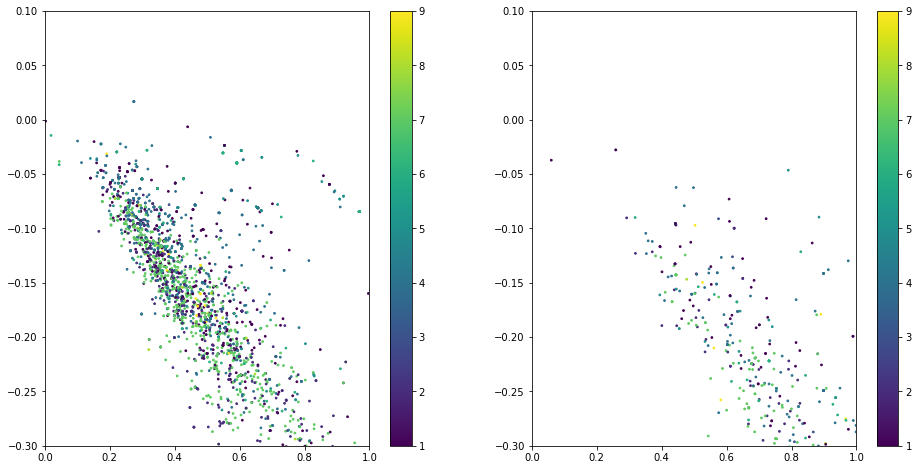

In [ ]:
# to see the distribution of the classes
# xall = np.concatenate([X_train_stacked.toarray(), X_test_stacked.toarray()])
# yall = np.concatenate([y_train, y_test])
# xall = normalize(xall, axis=0)

plt.figure(figsize=(16, 8))
plt.subplot(1,2,1)
tr_svd = TruncatedSVD(n_components=2, n_iter=250)
tsvd = tr_svd.fit_transform(X_train_stacked.toarray())

plt.xlim([0., 1.])
plt.ylim([-0.3, 0.1])
plt.scatter(tsvd[:,0], tsvd[:,1], c=y_train, s=3)
plt.colorbar()

plt.subplot(1,2,2)
tsvd = tr_svd.transform(X_test_stacked.toarray())

plt.xlim([0., 1.])
plt.ylim([-0.3, 0.1])
plt.scatter(tsvd[:,0], tsvd[:,1], c=y_test, s=3)
plt.colorbar()

## 4. Baseline Model Generation
- The idea behind random model is to create a reference error value (True - Generated), based on randomly generated value.
- This reference error gives a sense of how well our build model performce against the randomly generated values.
- How we construct random model for our multiclassification case:
  - Use Dummy classifier mode as the baseline model
  - performance metrics are Log_loss and accuracy

In [ ]:
# create baseline model
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train_stacked, y_train)

print("Accuracy and Log loss on Test Data using Dummy Model: ")
print(accuracy_score(y_test, dummy_clf.predict(X_test_stacked)), 
      log_loss(y_test, dummy_clf.predict_proba(X_test_stacked)))

# print(confusion_matrix(y_test, dummy_clf.predict(X_test.values)))
print()
print(classification_report(y_test, dummy_clf.predict(X_test.values)))

Accuracy and Log loss on Test Data using Dummy Model: 
0.17293233082706766 27.890711164010586

              precision    recall  f1-score   support

           1       0.16      0.15      0.15       114
           2       0.19      0.19      0.19        91
           3       0.05      0.06      0.05        18
           4       0.14      0.14      0.14       137
           5       0.16      0.17      0.16        48
           6       0.09      0.09      0.09        55
           7       0.28      0.27      0.27       191
           8       0.00      0.00      0.00         4
           9       0.00      0.00      0.00         7

    accuracy                           0.18       665
   macro avg       0.12      0.12      0.12       665
weighted avg       0.18      0.18      0.18       665



## 5. Model selection

In [ ]:
for i in range(3,10,2):
    alpha = 'n_neighbors=',str(i)
    clf = KNeighborsClassifier(n_neighbors=i)
    print (model_performance('Knn', 
                      clf,
                      alpha,
                      X_train_stacked, y_train,
                      X_test_stacked, y_test)[0])

  Model              alpha  train_log_loss  test_log_loss  Accuracy(%)
0   Knn  (n_neighbors=, 3)            0.76          1.105     0.627068
  Model              alpha  train_log_loss  test_log_loss  Accuracy(%)
0   Knn  (n_neighbors=, 5)           0.815           1.07     0.642105
  Model              alpha  train_log_loss  test_log_loss  Accuracy(%)
0   Knn  (n_neighbors=, 7)           0.866          1.082      0.62406
  Model              alpha  train_log_loss  test_log_loss  Accuracy(%)
0   Knn  (n_neighbors=, 9)           0.898          1.097     0.609023


In [ ]:
clf = MultinomialNB(alpha=0.001)
alpha = 0.001
model_performance('Naive Bayes', 
                  clf,
                  alpha,
                  X_train_stacked, y_train,
                  X_test_stacked, y_test)[0]


,Model,alpha,train_log_loss,test_log_loss,Accuracy(%)
0,Naive Bayes,0.001,0.735,1.245,0.613534


In [ ]:
alpha = 0.001
clf = SGDClassifier(class_weight='balanced', alpha=alpha, penalty='l2', random_state=42)
model_performance('Linear SVC (hinge)',
                  clf,
                  alpha,
                  X_train_stacked, y_train,
                  X_test_stacked, y_test)[0]

,Model,alpha,train_log_loss,test_log_loss,Accuracy(%)
0,Linear SVC (hinge),0.001,0.476,1.058,0.666165


In [ ]:
alpha ='n_estimators=',str(1500),'max depth=',str(10)

clf = RandomForestClassifier(n_estimators=1500, 
                             max_depth=10,
                             criterion='gini', 
                             random_state=42,
                             n_jobs=-1)

model_performance('Random Forest',
                  clf,
                  alpha,
                  X_train_stacked, y_train,
                  X_test_stacked, y_test)[0]

,Model,alpha,train_log_loss,test_log_loss,Accuracy(%)
0,Random Forest,"(n_estimators=, 1500, max depth=, 10)",0.586,1.157,0.586466


In [ ]:
alpha = 0.0001
clf = SGDClassifier(class_weight='balanced', alpha=alpha, penalty='l2', loss='log', random_state=42)
perf = model_performance('Logistic Regression',
                  clf,
                  alpha,
                  X_train_stacked, y_train,
                  X_test_stacked, y_test)
perf[0]

,Model,alpha,train_log_loss,test_log_loss,Accuracy(%)
0,Logistic Regression,0.0001,0.359,1.045,0.67218


In [ ]:
confusion_matrix(y_test, perf[1])

array([[ 68,   4,   0,  26,   6,   6,   4,   0,   0],
       [  2,  48,   0,   3,   3,   2,  33,   0,   0],
       [  0,   0,   7,   5,   1,   0,   5,   0,   0],
       [ 23,   1,   2, 101,   3,   1,   6,   0,   0],
       [  6,   2,   3,  10,  16,   0,  11,   0,   0],
       [  2,   1,   0,   4,   2,  34,  12,   0,   0],
       [  1,  19,   2,   3,   4,   0, 162,   0,   0],
       [  0,   1,   0,   0,   0,   0,   1,   2,   0],
       [  1,   0,   0,   1,   0,   0,   0,   0,   5]])

In [ ]:
print(classification_report(y_test, perf[1]))

              precision    recall  f1-score   support

           1       0.66      0.60      0.63       114
           2       0.63      0.53      0.57        91
           3       0.50      0.39      0.44        18
           4       0.66      0.74      0.70       137
           5       0.46      0.33      0.39        48
           6       0.79      0.62      0.69        55
           7       0.69      0.85      0.76       191
           8       1.00      0.50      0.67         4
           9       1.00      0.71      0.83         7

    accuracy                           0.67       665
   macro avg       0.71      0.58      0.63       665
weighted avg       0.66      0.67      0.66       665



## 6. Using Deep Learning model with Doc2Vec

In [ ]:
all_data.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating_Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [ ]:
from nltk.corpus import stopwords
from gensim.models.doc2vec import TaggedDocument
from gensim import utils

def constructTaggedSentences(data):
    sentences=[]
    for index, row in data.iteritems():
        sentences.append(TaggedDocument(utils.to_unicode(row).split(), ['Text' + '_%s' % str(index)]))
    return sentences

In [ ]:
all_data['TEXT'].head()

0    cyclin dependent kinases cdks regulate variety...
1    abstract background non small cell lung cancer...
2    abstract background non small cell lung cancer...
3    recent evidence demonstrated acquired uniparen...
4    oncogenic mutations monomeric casitas b lineag...
Name: TEXT, dtype: object

In [ ]:
sentences = constructTaggedSentences(all_data['TEXT'])
len(sentences)

3321

In [ ]:
sentences[0]

TaggedDocument(words=['cyclin', 'dependent', 'kinases', 'cdks', 'regulate', 'variety', 'fundamental', 'cellular', 'processes', 'cdk10', 'stands', 'one', 'last', 'orphan', 'cdks', 'activating', 'cyclin', 'identified', 'kinase', 'activity', 'revealed', 'previous', 'work', 'shown', 'cdk10', 'silencing', 'increases', 'ets2', 'v', 'ets', 'erythroblastosis', 'virus', 'e26', 'oncogene', 'homolog', '2', 'driven', 'activation', 'mapk', 'pathway', 'confers', 'tamoxifen', 'resistance', 'breast', 'cancer', 'cells', 'precise', 'mechanisms', 'cdk10', 'modulates', 'ets2', 'activity', 'generally', 'functions', 'cdk10', 'remain', 'elusive', 'demonstrate', 'cdk10', 'cyclin', 'dependent', 'kinase', 'identifying', 'cyclin', 'activating', 'cyclin', 'cyclin', 'orphan', 'cyclin', 'product', 'fam58a', 'whose', 'mutations', 'cause', 'star', 'syndrome', 'human', 'developmental', 'anomaly', 'whose', 'features', 'include', 'toe', 'syndactyly', 'telecanthus', 'anogenital', 'renal', 'malformations', 'show', 'star',

In [ ]:
from gensim.models import Doc2Vec

Text_INPUT_DIM = 300 

text_model = None
filename = 'docEmbeddings_5_clean.d2v'

text_model = Doc2Vec(min_count=1, 
                     window=5, 
                     vector_size=Text_INPUT_DIM, 
                     sample=1e-4, 
                     negative=5, 
                     epochs=10,
                     seed=1)
text_model.build_vocab(sentences)
text_model.train(sentences, total_examples=text_model.corpus_count, epochs=text_model.epochs)
text_model.save(filename)

In [ ]:
len(text_model.docvecs), text_model.docvecs[0].shape

(3321, (300,))

In [ ]:
X_text = np.zeros((all_data.shape[0], Text_INPUT_DIM))

for i in range(all_data.shape[0]):
    X_text[i] = text_model.docvecs[i]
    
print(X_text.shape)

(3321, 300)


In [ ]:
len(all_data['Gene'].unique()), len(all_data['Variation'].unique())

(264, 2996)

In [ ]:
from sklearn.decomposition import TruncatedSVD
Gene_INPUT_DIM=25

svd = TruncatedSVD(n_components=25, n_iter=Gene_INPUT_DIM, random_state=42)

X_gene = pd.get_dummies(all_data['Gene'])
X_gene_tr = svd.fit_transform(X_gene.values)

X_variation = pd.get_dummies(all_data['Variation'])
X_variation_tr = svd.fit_transform(X_variation.values)

In [ ]:
X_gene_tr.shape, X_variation_tr.shape, X_text.shape

((3321, 25), (3321, 25), (3321, 300))

In [ ]:
X_final = np.hstack((X_gene_tr, X_variation_tr, X_text))
y = all_data['Class']

In [ ]:
X_final.shape, y.shape

((3321, 350), (3321,))

- ouput encoding

In [ ]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(y)
y_ohe = np_utils.to_categorical((label_encoder.transform(y)))
print(y_ohe[0], y[0])

[1. 0. 0. 0. 0. 0. 0. 0. 0.] 1


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y, stratify = y, test_size=0.3)

In [ ]:
alpha = 0.001
clf = SGDClassifier(class_weight='balanced', alpha=alpha, penalty='l2', loss='log', random_state=42)
model_performance('Logistic Regression',
                  clf,
                  alpha,
                  X_train, y_train,
                  X_test, y_test)[0]

,Model,alpha,train_log_loss,test_log_loss,Accuracy(%)
0,Logistic Regression,0.001,0.976,1.295,0.5667


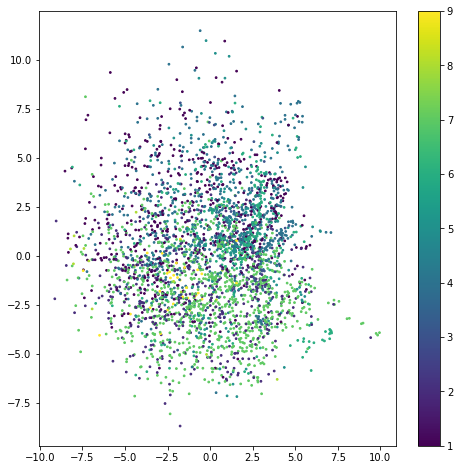

In [ ]:
pca_ = PCA(n_components=2).fit_transform(X_final)

plt.figure(figsize=(8, 8))
plt.scatter(pca_[:,0], pca_[:,1], c=y, s=3)
plt.colorbar()
plt.show()

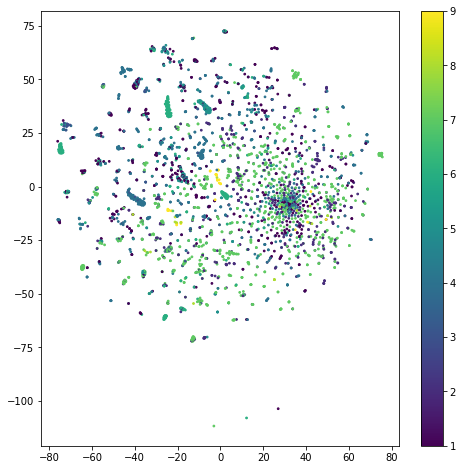

In [ ]:
tsne_ = TSNE(n_components=2).fit_transform(X_final)

plt.figure(figsize=(8, 8))
plt.scatter(tsne_[:,0], tsne_[:,1], c=y, s=3)
plt.colorbar()
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, Input, RepeatVector
from tensorflow.keras.optimizers import SGD, Adam

model = Sequential()
model.add(Dense(32, input_dim=Text_INPUT_DIM+Gene_INPUT_DIM*2, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(9, activation="softmax"))
model.summary()
    
model.compile(loss='categorical_crossentropy', 
                  optimizer=Adam(lr=0.001), 
                  metrics=['accuracy'])

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_43 (Dense)            (None, 32)                11232     
                                                                 
 dropout_22 (Dropout)        (None, 32)                0         
                                                                 
 dense_44 (Dense)            (None, 9)                 297       
                                                                 
Total params: 11,529
Trainable params: 11,529
Non-trainable params: 0
_________________________________________________________________


Final Training accuracy: 0.66 
Final Validation accuracy: 0.38


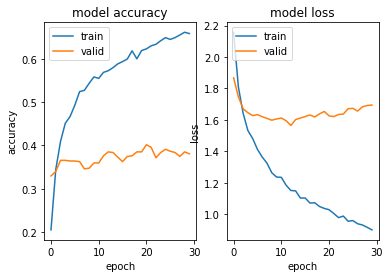

In [ ]:
history = model.fit(X_final, 
                    y_ohe, 
                    validation_split=0.2, 
                    epochs=30, 
                    batch_size=64, 
                    verbose=0)

print("Final Training accuracy: %.2f " % history.history['accuracy'][-1])
print("Final Validation accuracy: %.2f" % history.history['val_accuracy'][-1])

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')


plt.legend(['train', 'valid'], loc='upper left')
plt.show()

- not a good idea

# For exercise

- namedtuple

In [ ]:
from collections import namedtuple

Point = namedtuple('Point', ['x', 'y'])
p = Point(11, y=22)     # instantiate with positional or keyword arguments
p

Point(x=11, y=22)

In [ ]:
print(p[0] + p[1])          # indexable like the plain tuple (11, 22)
x, y = p
print(x, y)
p.x + p.y

33
11 22


33

- doc2vec
  - window: 모델 학습할때 앞뒤로 보는 단어의 수
  - vector_size: 벡터 차원의 크기
  - alpha: learning rate
  - min_count: 학습에 사용할 최소 단어 빈도 수
  - dm: 학습방법 1 = PV-DM, 0 = PV-DBOW
  - negative: Complexity Reduction 방법, negative sampling
  - max_epochs: 최대 학습 횟수


In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

data = ["I love machine learning. Its awesome.",
        "I love coding in python",
        "I love building chatbots",
        "they chat amagingly well"]

# tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(data)]
tagged_data = []

for i, _d in enumerate(data):
    d = TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)])
    tagged_data.append(d)

tagged_data

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


[TaggedDocument(words=['i', 'love', 'machine', 'learning', '.', 'its', 'awesome', '.'], tags=['0']),
 TaggedDocument(words=['i', 'love', 'coding', 'in', 'python'], tags=['1']),
 TaggedDocument(words=['i', 'love', 'building', 'chatbots'], tags=['2']),
 TaggedDocument(words=['they', 'chat', 'amagingly', 'well'], tags=['3'])]

In [ ]:
vec_size = 5
alpha = 0.025

model = Doc2Vec(vector_size = 5, min_count=1)  
model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=50)

In [ ]:
model.epochs, model.corpus_count

(50, 4)

In [ ]:
for i in range(len(model.docvecs)):
    print(model.docvecs[i])

[ 0.08726015 -0.03587561  0.00210199  0.06368762  0.01560563]
[-0.00844995  0.02899512 -0.03625074 -0.0331333  -0.00540545]
[0.00442133 0.00148324 0.01332327 0.01703816 0.03966627]
[-0.04856223 -0.00954694 -0.05661372  0.00070479 -0.03121219]


- CalibratedClassifierCV
  - When performing classification you often want not only to predict the class label, but also obtain a probability of the respective label. This probability gives you some kind of confidence on the prediction. Some models can give you poor estimates of the class probabilities and some even do not support probability prediction (e.g., some instances of SGDClassifier). **The calibration module allows you to better calibrate the probabilities of a given model, or to add support for probability prediction.**
  - **Well calibrated classifiers are probabilistic classifiers for which the output of the predict_proba method can be directly interpreted as a confidence level.**
  - This class uses cross-validation to both 
      - estimate the parameters of a classifier, and 
      - subsequently calibrate a classifier. 
  - With default ensemble=True, 
      - for each cv split it fits a copy of the base estimator to the training subset, and calibrates it using the testing subset. 
      - For prediction, predicted probabilities are averaged across these individual calibrated classifiers. 

In [ ]:
from sklearn.datasets import make_classification
from sklearn.naive_bayes import GaussianNB
from sklearn.calibration import CalibratedClassifierCV
X, y = make_classification(n_samples=100, n_features=2,
                         n_redundant=0, random_state=42)
base_clf = GaussianNB()
calibrated_clf = CalibratedClassifierCV(base_estimator=base_clf, cv=3)
calibrated_clf.fit(X, y)

CalibratedClassifierCV(base_estimator=GaussianNB(priors=None,
                                                 var_smoothing=1e-09),
                       cv=3, method='sigmoid')

In [ ]:
len(calibrated_clf.calibrated_classifiers_)

3

In [ ]:
calibrated_clf.predict_proba(X)[:5, :]

array([[0.11009913, 0.88990087],
       [0.07226373, 0.92773627],
       [0.92831861, 0.07168139],
       [0.9283446 , 0.0716554 ],
       [0.07186091, 0.92813909]])

In [ ]:
from sklearn.model_selection import train_test_split
X, y = make_classification(n_samples=100, n_features=2,
                            n_redundant=0, random_state=42)
X_train, X_calib, y_train, y_calib = train_test_split(X, y, random_state=42)
base_clf = GaussianNB()
base_clf.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [ ]:
calibrated_clf = CalibratedClassifierCV(
     base_estimator=base_clf,
     cv="prefit"
 )
calibrated_clf.fit(X_calib, y_calib)

CalibratedClassifierCV(base_estimator=GaussianNB(priors=None,
                                                 var_smoothing=1e-09),
                       cv='prefit', method='sigmoid')

In [ ]:
len(calibrated_clf.calibrated_classifiers_)

1

In [ ]:
calibrated_clf.predict_proba([[-0.5, 0.5]])

array([[0.93677315, 0.06322685]])

In [ ]:
normalize(np.array([[1., 2.],
                    [0.,1.]]), norm='l2', axis=0)

array([[1.        , 0.89442719],
       [0.        , 0.4472136 ]])

In [ ]:
normalize(np.array([[1., 2.],
                    [0.,1.]]), norm='l1', axis=0)

array([[1.        , 0.66666667],
       [0.        , 0.33333333]])